In [17]:
# The following line makes sure that when we plot stuff it shows up in the notebook
%matplotlib inline 

import csv
import numpy as np
import itertools
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import svm
from sklearn import decomposition
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

In [2]:
datafile = open("data.csv")
datareader = csv.DictReader(datafile)

banks = {}
bankpropertykeys = ["MWay_Dist", "Police_Dis", "N_UNP_RATE", "N_AGE", "N_INCOME", "N_DENSITY", "N_COM_DENS", "NUMBER"]
itt = 0
for row in datareader:
    #itt = itt+1
    id = row['ATM_ID']
    #id = itt

    banks[id] = row

# print banks.keys()
print "Number of banks:", len(banks)

Number of banks: 723


In [60]:
Y = []
X = []
for key, value in banks.items():
    Y.append(str(value['N_FREQ_ATTACK']))
    features = [value[x] for x in bankpropertykeys]
    X.append(features)

X = np.matrix(X).astype(np.float)

Y = np.array(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40)


clf = MultinomialNB()
clf.fit(X_train, y_train)

y_predict=[]
for x in X_test:
    y_predict.append(clf.predict(x)[0])

Accuracy on test data: 0.852534562212
Classification Report
              precision    recall  f1-score   support

Not Attacked       1.00      0.84      0.91       199
    Attacked       0.36      1.00      0.53        18

 avg / total       0.95      0.85      0.88       217



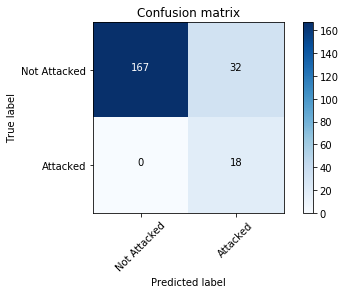

In [61]:
def plot_confusion_matrix(cm, class_labels, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_labels = ['Not Attacked', 'Attacked']

print 'Accuracy on test data:', accuracy_score(y_test, y_predict)

print 'Classification Report'
print classification_report(y_test, y_predict, target_names = class_labels)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, class_labels = class_labels, normalize=False, title='Confusion matrix')

plt.show()

In [47]:
def featuresClassify(features,model):
    f =  np.array([features[x] for x in bankpropertykeys]).astype(np.float)
    f = f.reshape([1, f.size])
    return model.predict_proba(f)

def dataPointClassify(id,model):
    f = np.array([banks.get(id)[x] for x in bankpropertykeys]).astype(np.float)
    f = f.reshape([1, f.size])
    return model.predict(f)

def getProb(id, model):
    f = np.array([banks.get(id)[x] for x in bankpropertykeys]).astype(np.float)
    f = f.reshape([1, f.size])
    #print(f.shape)
    return model.predict_proba(f)

def show_most_informative_features(feature_names, clf, n=20):
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
#         prob_1 = math.pow(10, coef_1)
#         prob_2 = math.pow(10, coef_2)
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)

In [66]:
"""Give probability for example ATM Attacks"""

#base features
features = {
    "MWay_Dist": 1000,
    "Police_Dis": 500,
    "N_UNP_RATE": 2,
    "N_AGE": 2,
    "N_INCOME": 2,
    "N_DENSITY": 2,
    "N_COM_DENS": 2,
    "NUMBER": 2
}
def printIt(features):
    print featuresClassify(features,clf)
    probabilities = np.around(featuresClassify(features,clf)[0], decimals=4)
    print "Not Attacked Probability", probabilities[0]
    print "Attacked Probability", probabilities[1]

features1 = features.copy()
features2 = features.copy()

#discrimination features
features1["Police_Dis"] = 680
features2["MWay_Dist"] = 750


printIt(features1)
printIt(features2)

    
    


[[ 0.02  0.98]]
Not Attacked Probability 0.0177
Attacked Probability 0.9823
[[  1.00e+00   3.65e-04]]
Not Attacked Probability 0.9996
Attacked Probability 0.0004


In [21]:
output = []
for key, value in banks.items():
    value['PROB_ATTACKED'] = getProb(key,clf)[0,1]
    output.append(value)

with open('results.csv', 'w') as csvfile:
    fieldnames = list(output[0].keys())
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for row in output:
        writer.writerow(row)

print(show_most_informative_features(bankpropertykeys,clf))

	-7.2555	NUMBER         		-0.4678	Police_Dis     
	-6.6429	N_AGE          		-1.0099	MWay_Dist      
	-6.6055	N_COM_DENS     		-5.8621	N_INCOME       
	-6.5414	N_DENSITY      		-6.3765	N_UNP_RATE     
	-6.3765	N_UNP_RATE     		-6.5414	N_DENSITY      
	-5.8621	N_INCOME       		-6.6055	N_COM_DENS     
	-1.0099	MWay_Dist      		-6.6429	N_AGE          
	-0.4678	Police_Dis     		-7.2555	NUMBER         
None


[[  9.89e-01  -1.46e-01   6.83e-05   8.23e-04  -8.60e-05  -2.08e-04
    4.62e-04   9.45e-05]
 [  1.46e-01   9.89e-01  -3.07e-04  -5.79e-04   2.94e-04   9.95e-05
   -3.79e-04  -1.86e-04]]
[(-0.14582093668794807, 'Police_Dis'), (-0.00020812469776423773, 'N_DENSITY'), (-8.6038973162338222e-05, 'N_INCOME'), (6.8309282651752331e-05, 'N_UNP_RATE'), (9.454474896078725e-05, 'NUMBER'), (0.00046187057804581496, 'N_COM_DENS'), (0.00082271723262671329, 'N_AGE'), (0.98931051743722587, 'MWay_Dist')]
[(-0.0005786169737560104, 'N_AGE'), (-0.00037926162005408413, 'N_COM_DENS'), (-0.00030715440879932623, 'N_UNP_RATE'), (-0.00018613324975825325, 'NUMBER'), (9.9467865358353336e-05, 'N_DENSITY'), (0.00029442738402642247, 'N_INCOME'), (0.14582168289414507, 'MWay_Dist'), (0.98931053395290525, 'Police_Dis')]


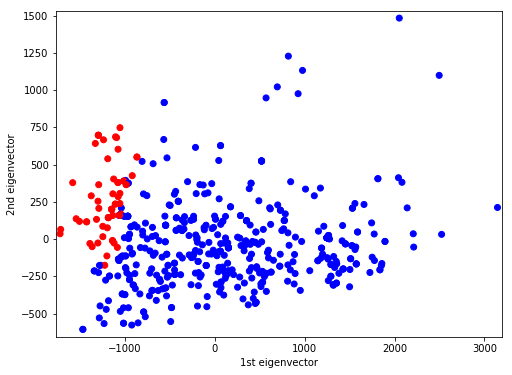

In [22]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train)
X = pca.transform(X_train)

print pca.components_

print sorted(zip(pca.components_[0], bankpropertykeys))

print sorted(zip(pca.components_[1], bankpropertykeys))

y_train = np.array(y_train.astype(np.int))

x_min, x_max = X[:, 0].min() - 50, X[:, 0].max() + 50
y_min, y_max = X[:, 1].min() - 50, X[:, 1].max() + 50
color_map = {0: (0, 0, 1), 1: (1, 0, 0)}

plt.figure(2, figsize=(8, 6))


colors = [color_map[y] for y in y_train]
plt.scatter(X[:, 0], X[:, 1], c=colors, cmap=plt.cm.Paired)
plt.xlabel('1st eigenvector')
plt.ylabel('2nd eigenvector')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

plt.show()